### Aprendizaje automático 
Segundo trabajo práctico: Aprendizaje de modelos de decisión
<br>Máster en Ingeniería Informática - Universidad de Sevilla
<br>Curso 2021-22

APELLIDOS: Fernández de Bobadilla Brioso
<br>NOMBRE: Guiomar

## Preprocesado de los datos
El conjunto de datos sobre el que vamos a trabajar es *Algerian Forest Fires Data Set* (https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++). Tal como se indica en la descripción está compuesto por 244 instancias de datos de 2 regiones de Argelia, 122 por cada región, y se clasifican en 'fire' (138) y 'not fire' (106).<br><br>
Comencemos leyendo el dataset, para ello vamos a utiliza pandas. Como el fichero está dividido en 2 partes, una para cada región, con el parámetro *skiprows* evitamos que las filas correspondientes a la separación y cabecera de cada parte sean leídas. Además, con el parámetro *names* renombramos las columnas (cabecera) del fichero.

In [1]:
import pandas as pd
features = ['day','month','year','Temp', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes']
datasetURL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
#filePath = 'Algerian_forest_fires_dataset_UPDATE.csv'
dataset = pd.read_csv(datasetURL, header = 0, names = features, skiprows = [0,124,125,126])

Una vez leído vamos a aplicar una serie de transformaciones para poder tratar los datos. En primer lugar vamos a eliminar las instancias que no estén completas, en este caso es solo una.<br>
Como las características 'DC' (Drought Code) y 'FWI' (Fire Weather Index) son números con formato string, los vamos a transformar para cambiar el tipo a numérico (float)<br>
La clasificación al ser valores categóricos también los vamos a transformar en 0 cuando clasifica como 'not fire' y en 1 cuando es 'fire'<br>

In [2]:
dataset = dataset[dataset['Classes'].notna()]
dataset['DC'] = dataset.apply(lambda x: float(x['DC']),axis=1)
dataset['FWI'] = dataset.apply(lambda x: float(x['FWI']),axis=1) 
dataset['Classes'] = dataset.apply(lambda x: 1 if x['Classes'].strip() == 'fire' else 0,axis=1)

Veamos la información del dataset tras estas transformaciones.

In [3]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 243
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   day      243 non-null    int64  
 1   month    243 non-null    int64  
 2   year     243 non-null    int64  
 3   Temp     243 non-null    int64  
 4   RH       243 non-null    int64  
 5   Ws       243 non-null    int64  
 6   Rain     243 non-null    float64
 7   FFMC     243 non-null    float64
 8   DMC      243 non-null    float64
 9   DC       243 non-null    float64
 10  ISI      243 non-null    float64
 11  BUI      243 non-null    float64
 12  FWI      243 non-null    float64
 13  Classes  243 non-null    int64  
dtypes: float64(7), int64(7)
memory usage: 28.5 KB
None


Las 3 primeras características (*day*, *month*, *year*) corresponden a la fecha de las observaciones de los datos, que son del periodo entre Junio y Septiembre de 2012. Vamos a ver si existe alguna correlación entre estas fechas y la clasificación. Para ello vamos a utilizar *seaborn* para visualizarla.

<AxesSubplot:>

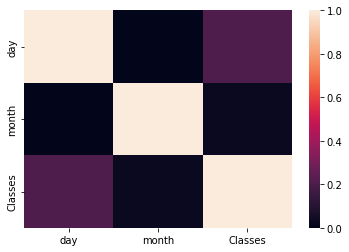

In [4]:
import seaborn as sb
corr = dataset[['day','month','Classes']].corr()
sb.heatmap(corr)

Como podemos ver las clasificación no está correlada con el mes porque es 0 y con el día también es casi 0, por tanto vamos a eliminar las características correspondientes a la fecha y de esta forma disminuimos la dimensionalidad del dataset.

In [5]:
dataset.drop(['day','month','year'],axis=1,inplace=True)

Como la clasificación es un atributo más del dataset, vamos a dividirlo en 2 variables: una con los datos y sus correspondientes valores para cada atributo (*X_data_pre*), y otra que contenga únicamente la clasificación correspondiente a cada instancia (*y_data*). De estamos forma podremos trabajar con ellas posteriormente.

In [6]:
algerian_forest_dataset = dataset.loc[:, dataset.columns != "Classes"]
X_data_pre = algerian_forest_dataset.values
y_data = dataset.loc[:, dataset.columns == "Classes"].values
X_names_pre = algerian_forest_dataset.columns

Esta sería la dimensión actual

In [7]:
print('Dimensión del conjunto de datos (X_data_pre): ', X_data_pre.shape)
print('Dimensión de la clasificación (y_data): ', y_data.shape)

Dimensión del conjunto de datos (X_data_pre):  (243, 10)
Dimensión de la clasificación (y_data):  (243, 1)


Veamos ahora si podemos reducir un poco más la dimensionalidad. Vamos a aplicar 2 técnicas vistas durante el curso.<br>
La primera es utilizar la función *removeFeature*, definida a continuación, la cual aplicando el modelo de regresión logística, va eliminando características y comprobando el rendimiento que se obtiene al eliminarla para quedarse con aquellas con las que se obtengan mejores resultados.

In [8]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import warnings
warnings.filterwarnings('ignore')
def removeFeature(X_data, y_data, num_features, X_names_feature, removedFeaturesList):
    model = LogisticRegression(random_state=486).fit(X_data, y_data)
    bestScore = model.score(X_data,y_data)
    bestX_data = np.copy(X_data)
    X_features = np.copy(X_names_feature)

    removedFeature = ''
    for i in range(X_data.shape[1]):
        X_data_aux = np.copy(X_data)
        X_data_reduced = np.delete(X_data_aux, i, 1)
        model = LogisticRegression().fit(X_data_reduced, y_data)
        score = model.score(X_data_reduced, y_data)
        if score > bestScore:
            bestScore = score
            bestX_data = X_data_reduced
            removedFeature = X_names_feature[i]
            X_names_feature_aux = np.copy(X_names_feature)
            X_features = np.delete(X_names_feature_aux, i, 0)

    if removedFeature != '':
        removedFeaturesList.append(removedFeature)
        if len(removedFeaturesList) < num_features:
            return removeFeature(bestX_data, y_data, num_features, X_features, removedFeaturesList)
        else:
            return bestX_data, X_features, removedFeaturesList, bestScore
    else:
        return bestX_data, X_features, removedFeaturesList, bestScore

X_data_result, X_names_result, removedFeatures_result, bestScore = removeFeature(X_data_pre, y_data, 4, X_names_pre, [])
print('Se han eliminado las siguientes {} características: {}'.format(len(removedFeatures_result), removedFeatures_result))
print('Rendimiento obtenido al eliminar las características: {:.3f}'.format(bestScore))
print('Forma del dataset resultante: ', X_data_result.shape)
print('Características finales: ', X_names_result)

Se han eliminado las siguientes 1 características: ['Ws']
Rendimiento obtenido al eliminar las características: 0.996
Forma del dataset resultante:  (243, 9)
Características finales:  ['Temp' 'RH' 'Rain' 'FFMC' 'DMC' 'DC' 'ISI' 'BUI' 'FWI']


Aplicando esta técnica eliminaríamos la caracteristica WS (Wind speed)<br><br>
Veamos ahora qué resultados obtenemos aplicando la clase *SelectFromModel* de *Scikit-learn*, que nos seleccionará las mejores características a partir de un modelo, esta vez utilizando el modelo *Linear SVC*

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

select2 = SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False, random_state=486))
select2.fit(X_data_pre,y_data)
seleccionadas = select2.get_support()
print('Características finales: ', X_names_pre[seleccionadas])

Características finales:  Index(['Temp', 'RH', 'Ws', 'FFMC', 'DC', 'FWI'], dtype='object')


Aplicando esta otra técnica se eliminarían 4 características: Rain, DMC (Duff Moisture Code), ISI (Initial Spread Index) y BUI (Buildup Index). Por tanto vamos a eliminarlas y quedarnos con el conjunto de datos final con el que trabajaremos.

In [10]:
X_names = X_names_pre[seleccionadas]
algerian_forest_dataset_final = dataset.loc[:, X_names]
X_data = algerian_forest_dataset_final.values
print('Características: ', algerian_forest_dataset_final.columns)
print('Dimensión del conjunto de datos (X_data): ', X_data.shape)
print('Dimensión de la clasificación (y_data): ', y_data.shape)

Características:  Index(['Temp', 'RH', 'Ws', 'FFMC', 'DC', 'FWI'], dtype='object')
Dimensión del conjunto de datos (X_data):  (243, 6)
Dimensión de la clasificación (y_data):  (243, 1)


## Aprendizaje de modelos
Ahora que tenemos el conjunto de datos preparado, vamos a dividirlo en un conjunto de entrenamiento y otro de pruebas. En este caso no vamos a generar también un conjunto de validación, pues el volumen de datos que tenemos no es muy grande.<br>
Una vez lo tenemos dividio vamos a normalizar los datos con *MinMaxScaler* para trabajar con valores entre 0 y 1.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=8, test_size = 0.3, stratify=y_data)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Como vamos a aplicar distintos modelos con distintos parámetros para posteriormente comparar los resultados obtenidos en cada uno de ellos, vamos a definir la función *searchParams* que recibe:
- *model*: Modelo que se va a entrenar
- *params*: los distintos parámetros y sus valores con los que se va a entrenar para seleccionar aquellos con los que se consiguen mejores resultados

Para esta búsqueda vamos a utilizar *GridSearchCV*, que aplica validación cruzada, y que va a tratar de optimizar la tasa de aciertos. Esta función devuelve el mejor modelo encontrado según los distintos parámetros que se han dado, la tasa de aciertos (*accuracy*), la medida F1 (media armónica de precision y recall) y la matriz de confusión.<br>

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
random_state = [8]
def searchParams(model, params):
    grid = GridSearchCV(model, params, cv=5)
    grid.fit(X_train, y_train)
    print("Mejor parámetro: ", grid.best_params_)
    print("Rendimiento en validación cruzada: {:.3f}".format(grid.best_score_))
    print("Rendimiento sobre conjunto de prueba: {:.3f}".format(grid.score(X_test, y_test)))
    pred = grid.predict(X_test)
    accuracy = accuracy_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    conf_matix = confusion_matrix(y_test,pred)
    return grid.best_estimator_, round(accuracy, 4), round(f1, 4), conf_matix

A continuación vamos a aplicar distintos modelos utilizando esta función y finalmente compararemos los resultados obtenidos en cada uno de ellos

### Aprendizaje basado en instancias
#### Knn

In [13]:
from sklearn.neighbors import KNeighborsClassifier
param_grid_knn = {
    'n_neighbors' : [5, 10, 2, 3],
    'p' : [1,2],
    'weights' : ['distance','uniform']
}
best_model_knn, accuracy_knn, f1_knn, conf_matix_knn = searchParams(KNeighborsClassifier(), param_grid_knn)

Mejor parámetro:  {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Rendimiento en validación cruzada: 0.947
Rendimiento sobre conjunto de prueba: 0.932


### Árboles de decisión

In [14]:
from sklearn.tree import DecisionTreeClassifier
param_grid_tree = {
    'random_state' : random_state,
    'max_depth' : [10, 3, 6, 8,],
    'min_samples_split' : [5, 10, 2, 15],
    'min_impurity_decrease' : [0.1, 0.001, 1, 0.15]
}
best_model_tree, accuracy_tree, f1_tree, conf_matix_tree = searchParams(DecisionTreeClassifier(), param_grid_tree)

Mejor parámetro:  {'max_depth': 10, 'min_impurity_decrease': 0.1, 'min_samples_split': 5, 'random_state': 8}
Rendimiento en validación cruzada: 0.971
Rendimiento sobre conjunto de prueba: 0.973


#### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
param_grid_rf = {
    'random_state' : random_state,
    'n_estimators' : [3, 5, 9, 15, 30],
    'max_depth' : [10, 3, 6, 8,],
}
best_model_rf, accuracy_rf, f1_rf, conf_matix_rf = searchParams(RandomForestClassifier(), param_grid_rf)

Mejor parámetro:  {'max_depth': 10, 'n_estimators': 5, 'random_state': 8}
Rendimiento en validación cruzada: 0.976
Rendimiento sobre conjunto de prueba: 0.945


#### Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid_gb = {
    'random_state' : random_state,
    'n_estimators' : [3, 5, 9, 15, 30],
    'max_depth' : [10, 3, 6, 8,],
}
best_model_gb, accuracy_gb, f1_gb, conf_matix_gb = searchParams(GradientBoostingClassifier(), param_grid_gb)

Mejor parámetro:  {'max_depth': 10, 'n_estimators': 3, 'random_state': 8}
Rendimiento en validación cruzada: 0.965
Rendimiento sobre conjunto de prueba: 0.973


### Modelos probabilísticos
#### Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
param_grid_nb = {
    'alpha': [0.0001,0.001, 0.01,0.1, 1, 10,100,200]
}
best_model_nb, accuracy_nb, f1_nb, conf_matix_nb = searchParams(MultinomialNB(), param_grid_nb)

Mejor parámetro:  {'alpha': 0.0001}
Rendimiento en validación cruzada: 0.882
Rendimiento sobre conjunto de prueba: 0.822


### Modelos lineales
#### Regresión logística

In [18]:
param_grid_rl = {
    'random_state' : random_state,
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty' : ['l1','l2']
}
best_model_rl, accuracy_rl, f1_rl, conf_matix_rl = searchParams(LogisticRegression(), param_grid_rl)

Mejor parámetro:  {'C': 100, 'penalty': 'l2', 'random_state': 8}
Rendimiento en validación cruzada: 0.959
Rendimiento sobre conjunto de prueba: 0.945


#### Modelos lineales SVC

In [19]:
param_grid_lsvc = {
    'random_state' : random_state,
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty' : ['l1','l2']
}
best_model_lsvc, accuracy_lsvc, f1_lsvc, conf_matix_lsvc = searchParams(LinearSVC(), param_grid_lsvc)

Mejor parámetro:  {'C': 100, 'penalty': 'l2', 'random_state': 8}
Rendimiento en validación cruzada: 0.959
Rendimiento sobre conjunto de prueba: 0.945


### Redes neuronales

In [20]:
from sklearn.neural_network import MLPClassifier
param_grid_nn = {
    'random_state' : random_state,
    'solver': ['sgd','lbfgs'],
    'alpha': [0.0001,0.001, 0.01,0.1, 1, 10,100,200]
}
best_model_nn, accuracy_nn, f1_nn, conf_matix_nn = searchParams(MLPClassifier(), param_grid_nn)

Mejor parámetro:  {'alpha': 0.01, 'random_state': 8, 'solver': 'lbfgs'}
Rendimiento en validación cruzada: 0.965
Rendimiento sobre conjunto de prueba: 0.932


## Resultados

En la siguiente tabla se muestra la tasa de aciertos (*accuracy*) y la medida F1 (media armónica de precision y recall) obtenidas en cada uno de los modelos.

In [21]:
metrics = {
    "accuracy": [accuracy_knn, accuracy_tree, accuracy_rf, accuracy_gb, accuracy_nb, accuracy_rl, accuracy_lsvc, accuracy_nn],
    "f1" : [f1_knn, f1_tree, f1_rf, f1_gb, f1_nb, f1_rl, f1_lsvc, f1_nn],
    #"matriz de confusión" : [conf_matix_knn, conf_matix_tree, conf_matix_rf, conf_matix_gb, conf_matix_nb, conf_matix_rl, conf_matix_lsvc, conf_matix_nn]
}
print ("{:<10} {:<10} {:<10} {:<15} {:<18} {:<15} {:<20} {:<15} {:<15}".format('Métria','KNN','Árboles','Random Forest','Gradient boosting', 'Naive Bayes', 'Regresión logística', 'Lineal SVC', 'Redes neuronales'))
for key, value in metrics.items():
    knn, tree, rf, gb, nb, rl, lsvc, nn = value
    if key != "matriz de confusión":
        print("{:<10} {:<10} {:<10} {:<15} {:<18} {:<15} {:<20} {:<15} {:<15}".format(key, knn, tree, rf, gb, nb, rl, lsvc, nn))
    else:
        print(knn, tree, rf, gb, nb, rl, lsvc, nn)

Métria     KNN        Árboles    Random Forest   Gradient boosting  Naive Bayes     Regresión logística  Lineal SVC      Redes neuronales
accuracy   0.9315     0.9726     0.9452          0.9726             0.8219          0.9452               0.9452          0.9315         
f1         0.9412     0.9762     0.9512          0.9762             0.8571          0.9512               0.9512          0.9383         


Ya que el conjunto de datos no está balanceado, la medida en la que habría que poner más foco sería f1.<br><br>
Viendo los resultados obtenidos, los mejores modelos para clasificar serían los Árboles de decisión y Gradiente boosting, ya que son con los que se obtienen la mejor medida f1, y además una buena tasa de aciertos (mismos resultados para ambos modelos).<br><br>
Vamos a mostrar dicho árbol de precisión, en el que vemos que con la característica FFMC (Fine Fuel Moisture Code, Código de humedad de combustible fino) podemos realizar la clasificación

zsh:1: command not found: dot


<Figure size 432x288 with 0 Axes>

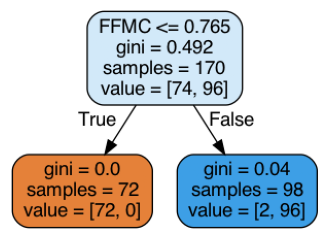

In [22]:
from sklearn.tree import export_graphviz
from matplotlib import pyplot as plt

export_graphviz(best_model_tree, out_file="algerian_forest_tree.dot", feature_names=X_names, rounded=True, filled=True)
!dot -Tpng algerian_forest_tree.dot -o algerian_forest_tree.png
plt.clf()
image = plt.imread("algerian_forest_tree.png")
height, width, depth = image.shape
dpi = 70
figsize = width / float(dpi), height / float(dpi)
plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
plt.axis('off')
plt.imshow(image)
plt.show()

Con Random Forest, Regresión logística y lineal SVC también se obtienen los mismos resultados, con una media armónica también bastante buena.<br><br>
En el lado opuesto se encuentra Naive Bayes, que es el modelo con el que se obtienen los peores resultados.